We will try to generate a Johann Sebastian bach music style with LSTM

We will train a network to learn a language model and then use it to generate new sequences.

We will learn how J. S. Bach's "Cello suite" have been composed.

Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their "MIDI files"
A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

We will first train a language model on the whole set of MIDI files of the "Cello suites".
We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.


## Import packages

In [ ]:
! pip install pretty_midi

import os
import pretty_midi
from scipy.io import wavfile
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np
import glob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 7.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=cd534b51c232aad411b4616ade7f9478e50e1fdb207796c031738451c94daf7d
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


# Get the data

In [ ]:
# n_x --- the number of notes (here we consider the problem as a multi-class with n_x classes)
n_x = 79
# max_midi_T_x --- the maximum number of notes we read in each midi_file
max_midi_T_x = 1000
# model_T_x --- the length of the sequences considered for the RNN model
#model_T_x = 200
model_T_x = 100
# model_n_a --- the number of neurons of each layer of the network
#model_n_a = 256
model_n_a = 32

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [ ]:
DIR = './'
import urllib.request
midi_file_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midi_file in midi_file_l:
  #if os.path.isfile(DIR + midi_file) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midi_file, DIR + midi_file)

midi_file_l = glob.glob(DIR + 'cs*.mid')
print(midi_file_l)

['./cs1-1pre.mid', './cs4-5bou.mid', './cs3-6gig.mid', './cs1-3cou.mid', './cs3-3cou.mid', './cs2-4sar.mid', './cs4-4sar.mid', './cs2-2all.mid', './cs1-5men.mid', './cs4-2all.mid', './cs5-5gav.mid', './cs6-2all.mid', './cs4-1pre.mid', './cs3-4sar.mid', './cs4-6gig.mid', './cs6-4sar.mid', './cs3-5bou.mid', './cs6-6gig.mid', './cs1-4sar.mid', './cs5-2all.mid', './cs6-1pre.mid', './cs2-3cou.mid', './cs5-1pre.mid', './cs3-1pre.mid', './cs1-2all.mid', './cs2-6gig.mid', './cs2-5men.mid', './cs5-4sar.mid', './cs5-6gig.mid', './cs6-3cou.mid', './cs2-1pre.mid', './cs1-6gig.mid', './cs6-5gav.mid', './cs3-2all.mid', './cs5-3cou.mid', './cs4-3cou.mid']


## Read and convert all MIDI files

We illustrate here the content of a MIDI file. Each file contains a list of notes to be played over time. Each note is characterized by
- its pitch (in MIDI note number, la3=A4=69)
- its start time (when to start playing the note)
- its stop time (when to stop playing the note)
- its duration (which is computed as stop-start)

In [ ]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midi_file_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes[:20]:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 43, start: 0.000000, end: 0.187500, duration: 0.187500
pitch: 50, start: 0.187500, end: 0.375000, duration: 0.187500
pitch: 59, start: 0.375000, end: 0.562500, duration: 0.187500
pitch: 57, start: 0.562500, end: 0.750000, duration: 0.187500
pitch: 59, start: 0.750000, end: 0.937500, duration: 0.187500
pitch: 50, start: 0.937500, end: 1.125000, duration: 0.187500
pitch: 59, start: 1.125000, end: 1.312500, duration: 0.187500
pitch: 50, start: 1.312500, end: 1.500000, duration: 0.187500
pitch: 43, start: 1.500000, end: 1.687500, duration: 0.187500
pitch: 50, start: 1.687500, end: 1.875000, duration: 0.187500
pitch: 59, start: 1.875000, end: 2.062500, duration: 0.187500
pitch: 57, start: 2.062500, end: 2.250000, duration: 0.187500
pitch: 59, start: 2.250000, end: 2.437500, duration: 0.187500
pitch: 50, start: 2.437500, end: 2.625000, duration: 0.187500
pitch: 59, start: 2.625000, end: 2.812500, duration: 0.187500
pitch: 50, start: 2.812500, end: 3.000000, duration: 0.187500
pitch: 4

We read each MIDI file and for each only retains the pitch (we name it note) information.
We convert the list of note  to a one-hot-encoding matrix X_ohe of dimensions (midi_T_x, n_x) where n_x is the number of possible musical notes.
The length of the sequences midi_T_x can vary from one sequence to the other.



In [ ]:
def F_convert_midi_2_list(midi_file_l, max_midi_T_x):
    """
    read the notes within all midi files
    truncate the length if > max_midi_T_x

    Parameters
    ----------
    midi_file_l:
        list of MIDI files
    max_midi_T_x:
        the maximum number of notes we read in a given midi_file

    Returns
    -------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    """
    X_list = []

    for midi_file in midi_file_l:
        # --- read the MIDI file
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        midi_T_x = len(note_l) if len(note_l) < max_midi_T_x else max_midi_T_x

        # --- convert to one-hot-encoding
        X_ohe=np.zeros((midi_T_x,n_x))
        for k in range(midi_T_x):
               X_ohe[k][note_l[k]-1]=1

        X_list.append(X_ohe)

    return X_list

In [ ]:
X_list = F_convert_midi_2_list(midi_file_l, max_midi_T_x)
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(593, 79)
(1000, 79)
(644, 79)


## Display the set of notes over time for a specific track

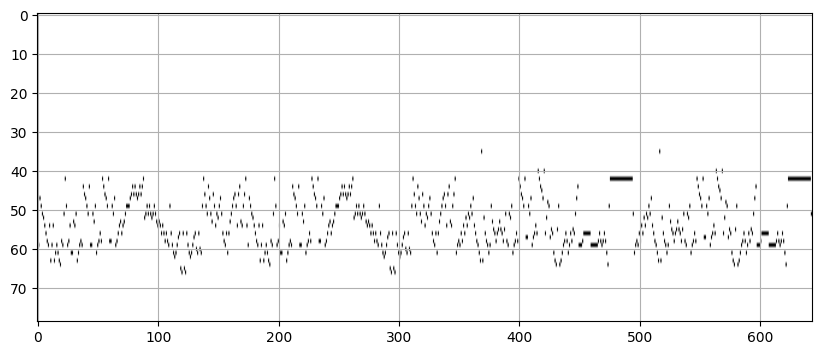

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

We want to train a language model, i.e. a model thats predict a note given past notes: $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.

A simple way to do this is to create (for each MIDI sequence and for each possible starting note t within this MIDI sequence) two sequences:
- an input sequence $x$: which contains a sub-sequence of length model_T_x;  this sub-sequence range from t to t+model_T_x-1
- an output sequence $y$ :which contains the same sub-sequence but delayed by one time step: ranging from t+1 to t+model_T_x



In [ ]:
def F_convert_list_2_data(X_list, model_T_x, sequence_step=1):
    """
    convert X_list to input X_train and output Y_train training data

    Parameters
    ----------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time

    Returns
    -------
    X_train:
        the set of all m input sequences; np.array of shape (m, model_T_x, n_x)
    Y_train:
        the set of all m output sequences; np.array of shape (m, model_T_x, n_x)

            note:   m is the total number of training items,
                    it is be larger than the number of MIDI files since we use several starting time t in each MIDI file
    """

    if student:
        # --- START CODE HERE (02)
        X_train_list = []
        Y_train_list = []

        for k in range(0,len(X_list)):
          lenlist=len(X_list[k])
          for n in range(0,lenlist-model_T_x-1,sequence_step):
            X_train_list.append(X_list[k][n:n+model_T_x])
            Y_train_list.append(X_list[k][n+1:n+model_T_x+1])

        # --- END CODE HERE

    X_train = np.asarray(X_train_list)
    Y_train = np.asarray(Y_train_list)

    return X_train, Y_train

X_train.shape: (20865, 100, 79)
Y_train.shape: (20865, 100, 79)


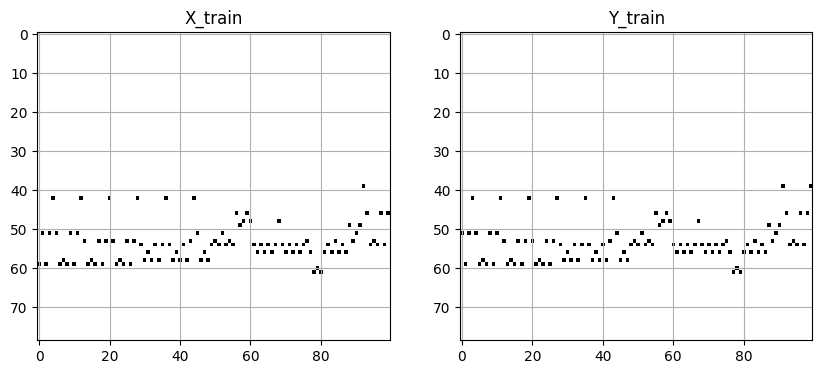

In [ ]:
X_train, Y_train = F_convert_list_2_data(X_list, model_T_x)
# --- X_train is of shape (m, model_T_x, n_x)
print("X_train.shape:", X_train.shape)
# --- Y_train is of shape (m, model_T_x, n_x)
print("Y_train.shape:", Y_train.shape)


plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(X_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('X_train')
plt.subplot(1,2,2); plt.imshow(Y_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('Y_train')
plt.set_cmap('gray_r')

# Training the language model

To learn the language model we will train an RNN with input X_train and output Y_train.  
For each example, we give to the network a sequence of notes from t to t+model_T_x-1  and ask the network to predict the following note of each sequence t+1 to t+model_T_x.




In [ ]:
# --- Create the model
K.clear_session()


model = Sequential()
model.add(LSTM(model_n_a,input_shape=(model_T_x,n_x),return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(model_n_a,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(model_n_a,return_sequences=True))
model.add(Dense(model_n_a,activation="tanh"))
model.add(Dropout(0.3))
model.add(Dense(n_x,activation="softmax"))


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 32)           14336     
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           8320      
                                                                 
 dropout_1 (Dropout)         (None, 100, 32)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 32)           8320      
                                                                 
 dense (Dense)               (None, 100, 32)           1056      
                                                                 
 dropout_2 (Dropout)         (None, 100, 32)           0

In [ ]:
# --- Compile and fit the model
callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.1, shuffle=True, callbacks=[callback])

Epoch 1/100
1174/1174 [==============================] - 34s 19ms/step - loss: 3.1119 - accuracy: 0.1040 - val_loss: 2.7293 - val_accuracy: 0.1390
Epoch 2/100
1174/1174 [==============================] - 21s 18ms/step - loss: 2.6687 - accuracy: 0.1585 - val_loss: 2.5831 - val_accuracy: 0.1706
Epoch 3/100
1174/1174 [==============================] - 20s 17ms/step - loss: 2.5818 - accuracy: 0.1754 - val_loss: 2.5550 - val_accuracy: 0.1785
Epoch 4/100
1174/1174 [==============================] - 20s 17ms/step - loss: 2.5222 - accuracy: 0.1923 - val_loss: 2.5697 - val_accuracy: 0.1889
Epoch 5/100
1174/1174 [==============================] - 21s 18ms/step - loss: 2.4637 - accuracy: 0.2132 - val_loss: 2.5578 - val_accuracy: 0.2057
Epoch 6/100
1174/1174 [==============================] - 19s 17ms/step - loss: 2.3993 - accuracy: 0.2398 - val_loss: 2.5616 - val_accuracy: 0.2079


# Generating a new sequence by sampling the language model

To generate a new sequence from the language model,

- we first randomly choose a starting note among the n_x possible ones. For this you can use
np.random.multinomial and either
    - assume an uniform distribution
    - compute a prior note distribution (you can do this by computing the number of occurences of each notes in the training set)
- we then create an artificial input x that can be used by our model. Our model requires data x of shape (m, T_x, n_x). In our case
    - m=1 since we have only one sequence,
    - T_x should be the length used when training our model so it is model_T_x and
    - n_x is the number of notes.
- we set the data at time t=0, x[0,0,:], to our random note (after converting it to a one-hot-encoding)
- we then feed our model with this data. The model has been trained to predict $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.
The output of the model y is of shape (m, T_x, n_x). But only the first value is meaningfull so far.
The output value y at t=0 is $p(x^{<1>} | x^{<0>})$, i.e. the probability of each note to be the second note given our first note as input. Actually y at t=0 (noted y[0,0,:]) is a vector that represents the probability of each of the n_x notes given the one at t=0. We can then either
    - (a) get the most likely class from the vector y[0,0,:] (np.argmax) or
    - (b) consider the vector y[0,0,:] as a multinomial distribution and sample from it (np.random.multinomial). If the vector is too peaky (one of the probability is much larger than the other) we can flatten it using a temperature scaling (see below).
- whathever (a) or (b), the selected note is now considered as the note at t=1. We therefore add it (after conversion to one-hot-encoding) to the input data $x$ at time t=1: x[0,1,:].
- we then feed our model with this new x. The output of the model at t=1, y[0,1,:], is $p(x^{<2>} | x^{<0>}, x^{<1>})$. We then either perform (a) or (b), plugs the new selected notes as the input $x$ at t=2, x[0,2,:], and repeat the process for the following times until we reach model_T_x.



We will apply a temperature $T$ parameter to a discrete probability $\{p_c\}_{c \in \{1,...,K\}}$, you can use
$$p'_c = \frac{e^{\log(p_c)/T}}{\sum_{k=1}^K e^{\log(p_k)/T}}$$ where $K$ is the number of classes. We use it order to smooth the probability distribution so that we can have a diversity of possible note to play

In [ ]:
def F_get_max_temperature(proba_v, temperature=1):
    """
    apply a temperature to the input probability
    consider it as a multinomial distribution
    sample it


    proba_v: np.array(n_x)
        input probability vector
    temperature: scalar float
        temperature parameters to apply to proba_v,
        >1 leads to more flatten probability,
        <1 leads to more peaky probability

    """

    pred_v = np.exp(np.log(proba_v)/temperature)/np.sum(np.exp(np.log(proba_v)))
    index_pred = np.argmax(np.random.multinomial(1,pred_v))


    return index_pred, pred_v

In [ ]:
def F_sample_new_sequence(model, prior_v):
    """
    sample the trained language model to generate new data


    """
    x=np.zeros((1,model_T_x,n_x))
    prediction_l = []
    note_l = []
    x[0,0,:]= np.random.multinomial(1,prior_v)
    print(x[0,0,:])

    for n in range(model_T_x-1):
          prediction=model.predict(x)
          print(prediction)
          prediction_l.append(prediction[0,n,:])
          index_pred,pred_v=F_get_max_temperature(prediction[0,n,:])
          note_l.append(index_pred)
          x[0,n+1,index_pred]=1


    return note_l, prediction_l

### Display the generated sequence

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 1s 1s/step
[[[8.10060044e-07 1.98561361e-06 3.93750406e-06 ... 2.00439013e-06
   2.08587735e-05 1.85210811e-05]
  [4.85095839e-08 9.87180542e-08 2.67451327e-07 ... 1.19872908e-07
   1.30217950e-06 1.57075522e-06]
  [3.54657175e-08 6.69749198e-08 1.86928006e-07 ... 8.17457035e-08
   8.55794667e-07 9.99771828e-07]
  ...
  [3.72726809e-08 7.38163095e-08 1.79220521e-07 ... 1.01269741e-07
   2.19339972e-06 1.68752808e-06]
  [3.72736260e-08 7.40102024e-08 1.79481631e-07 ... 1.01617495e-07
   2.21752975e-06 1.71252213e-06]
  [3.72781557e-08 7.40942667e-08 1.79284129e-07 ... 1.01767078e-07
   2.22831068e-06 1.72733917e-06]]]
1/1 [==============================] - 0s 34ms/step
[[[8.10060044e-07 1.98561361e-06 3.9375040

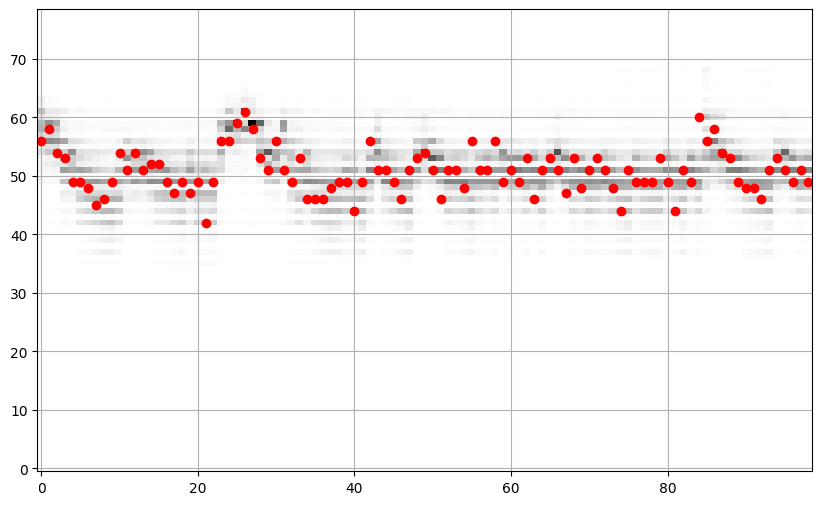

In [ ]:
if False:
    prior_v = np.ones(n_x)/n_x
else:
    sum_v = np.zeros(n_x)
    for X_ohe in X_list: sum_v += np.sum(X_list[0], axis=0)
    prior_v = sum_v/np.sum(sum_v)

note_l, prediction_l = F_sample_new_sequence(model, prior_v)

print(note_l)
plt.figure(figsize=(10, 6))
plt.imshow(np.asarray(prediction_l).T, aspect='auto', origin='lower')
plt.plot(note_l, 'ro')
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (note_l) we transform it to a new MIDI file and perform  rendering of it in an audio file.

In [ ]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

# Now it is time to listen to this masterpiece:




In [ ]:
%matplotlib inline
audio_data = new_midi_data.synthesize(fs=44100)
IPython.display.Audio(audio_data, rate=44100)